<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_JNJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-tw36fbvn
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-tw36fbvn
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dfd9739e4bdcce166dc6326afcde41af9a5f8641_-cp36-none-any.whl size=119874 sha256=6b9ffed984da3261785a7ad6516f72bcdd116bd005266874d9ce8e2fa8179e91
  Stored in directory: /tmp/pip-ephem-wheel-cache-cntkqk7t/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [98]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/JNJ/df_JNJ_20drtn_features.csv')

In [99]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,43.078384,47.345041,48.599280,39.713287,-58.775436,-58.775436,-53.136499,-83.044048,43.686867,34.711867,35.435532,35.582907,-0.792016,0.642779,-0.127568,-0.555730,-0.666135,-0.068959,-0.116214,-0.131071,-0.071923,-0.424266,-0.424266,-0.424266,-0.424266,62.310435,-15.618465,-33.382465,-22.762252,-23.599768,-40.013463,0.151902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129025,0.003559,0.137965,-0.000923,0.153374,-0.001458,27.549999,2.949999,4.019999,-2.733426e+05,-2.733426e+05,-2.733426e+05,-2.733426e+05,0.059215,-0.020835,0.000270,-0.028653,-0.111091,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,35.950651,37.307684,42.370662,37.409950,-95.880267,-95.880267,-94.465027,-97.997360,41.941453,33.941182,35.281638,32.198421,-1.788285,-1.803961,-0.726276,-2.643245,-2.069739,-0.077678,-0.114887,-0.129520,-0.073463,-0.499672,-0.499672,-0.499672,-0.499672,-105.461992,-127.192976,-169.542173,-182.004805,-24.217638,-38.096092,0.107840,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.153153,0.023059,0.151132,0.017481,0.154041,-0.000841,27.490000,-0.059999,0.949999,-5.758274e+06,-5.758274e+06,-5.758274e+06,-5.758274e+06,-0.113311,-0.046764,-0.045708,-0.059272,0.230530,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,33.153166,39.902063,42.817989,34.565585,-94.482635,-94.482635,-94.482635,-97.916619,31.927140,33.549037,35.179401,29.666188,-0.292630,-2.851258,-1.446244,-3.946745,-1.128481,-0.092818,-0.116431,-0.129227,-0.075099,-0.567415,-0.567415,-0.567415,-0.567415,-104.786585,-131.997586,-168.155583,-202.026997,-25.469975,-36.744979,0.280706,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.134308,0.001867,0.145264,0.011197,0.153699,-0.001820,29.379999,1.889999,3.099998,-4.692597e+06,-4.692597e+06,-4.692597e+06,-4.692597e+06,-0.226304,-0.108748,-0.022963,-0.077130,-0.047296,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,39.442006,47.722786,52.179023,37.631985,-52.611929,-56.206904,-56.206904,-83.463536,34.254583,34.677510,40.616877,32.292119,1.809876,-0.303373,-0.319286,-2.008792,0.904973,-0.099054,-0.116214,-0.128281,-0.076604,-0.525478,-0.525478,-0.525478,-0.525478,-9.962449,-34.692034,-66.904684,-86.199914,-25.365715,-34.178812,0.913461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174511,0.055078,0.159300,0.022899,0.162117,0.005311,26.360001,-3.019999,0.840000,1.916760e+06,1.916760e+06,1.916760e+06,1.916760e+06,-0.122242,-0.076011,0.009903,-0.072812,-0.041731,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,40.290705,42.784993,53.170990,37.921769,-40.517285,-52.413781,-52.413781,-82.031237,43.819853,42.319817,41.046004,32.352599,0.176170,1.690784,-0.918742,-0.777287,-0.666987,-0.098223,-0.114262,-0.126618,-0.077957,-0.477857,-0.477857,-0.477857,-0.477857,67.842231,41.870270,-8.819812,-20.803189,-24.676205,-30.883405,0.414141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168205,0.044101,0.146100,0.010752,0.162217,0.009559,27.219999,0.859999,2.619999,1.759360e+06,1.759360e+06,1.759360e+06,1.759360e+06,-0.074192,-0.042048,-0.033272,-0.083317,-0.036911,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [100]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [101]:
from_date='2010-01-01'
to_date='2020-01-01'

In [102]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [103]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,36.923033,35.832475,46.622653,70.850367,-93.037944,-93.081740,-93.081740,-25.342506,67.878983,51.662850,47.706534,69.330742,-1.159555,-1.509788,-1.555285,-0.683552,-0.668117,0.080594,0.141051,0.151412,0.098780,0.414800,0.414800,0.414800,0.414800,-152.855975,-209.266648,-192.469168,-61.967107,34.963155,41.123263,0.137500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.081167,0.036394,0.065862,0.009105,0.077766,-0.008299,19.350000,-0.690001,-0.580000,-2.564685e+06,-2.564685e+06,-2.564685e+06,-2.564685e+06,-0.386843,-0.248070,-0.171445,0.110388,0.122751,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,52.479895,44.928091,51.365539,71.181083,-60.126802,-60.126802,-60.377630,-18.750121,68.742347,53.326819,53.729069,69.718165,0.813384,0.062092,-0.754551,0.186531,0.124272,0.065631,0.130945,0.146228,0.099561,0.379484,0.379484,0.379484,0.379484,-63.063234,-122.936446,-121.816024,-58.698398,31.331805,37.865863,0.873234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092441,0.048515,0.072401,0.016023,0.078942,0.002551,19.160000,-0.190001,-0.850000,5.732550e+05,5.732550e+05,5.732550e+05,5.732550e+05,-0.132638,-0.134856,-0.096727,0.114420,0.234084,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,43.871848,37.217793,45.739949,67.152949,-84.939758,-84.939758,-85.029958,-29.521839,56.342281,53.297998,53.790739,67.065922,-0.713724,-1.066788,-1.417350,-0.836816,-0.404667,0.048622,0.119724,0.140177,0.100093,0.310795,0.310795,0.310795,0.310795,-86.386386,-139.544507,-160.263794,-137.137522,27.642655,34.305130,0.409838,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.097585,0.057649,0.076571,0.030978,0.080518,0.004936,19.059999,-0.100000,-0.900000,-1.289391e+06,-1.289391e+06,-1.289391e+06,-1.289391e+06,-0.140461,-0.198208,-0.101525,0.081716,-0.172334,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,45.359369,43.416239,49.705871,66.525654,-67.231759,-67.231759,-67.415889,-25.052263,57.147858,51.388946,58.336485,66.798372,0.343800,0.437977,-0.310518,-0.557535,-0.264054,0.033745,0.108688,0.133825,0.100437,0.270987,0.270987,0.270987,0.270987,-64.692993,-99.663269,-132.468407,-141.512827,24.037355,30.674851,0.920630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099753,0.043612,0.077275,0.025438,0.078921,0.004932,18.129999,-0.930000,-3.550001,-2.804145e+05,-2.804145e+05,-2.804145e+05,-2.804145e+05,0.009828,-0.089246,-0.109143,0.081607,-0.275519,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,44.428683,42.458576,48.303704,64.935974,-66.666667,-66.666667,-66.853972,-24.843450,59.929188,58.135930,58.128514,69.191271,0.015577,-0.356859,-0.711192,-0.741879,-0.849152,0.021221,0.098070,0.127312,0.100606,0.237508,0.237508,0.237508,0.237508,98.837581,-32.734441,-47.463104,-63.655182,20.736968,27.369730,0.283783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098853,0.044199,0.073776,0.022130,0.076850,0.005414,17.549999,-0.580000,-2.490002,-1.603516e+05,-1.603516e+05,-1.603516e+05,-1.603516e+05,-0.034944,-0.109748,-0.140257,0.072534,0.009838,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [104]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,89.447132,86.992061,84.091167,72.864684,-22.446411,-15.239725,-14.026780,-8.670233,70.794310,69.251918,62.691521,62.290474,0.488470,1.741432,3.310222,4.046155,7.050715,0.308256,0.258108,0.203883,0.056943,2.769830,2.769830,2.769830,2.769830,116.508413,156.615891,176.436963,171.744786,70.167271,72.431633,0.414473,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.096640,0.006092,0.100678,-0.029880,0.135559,-0.079879,12.51,0.010000,-0.120000,9.782332e+06,9.782332e+06,9.782332e+06,9.782332e+06,-0.051868,0.068590,0.169219,0.172665,0.543629,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,88.807335,89.383361,83.943112,78.410661,-17.654416,-11.986257,-11.032259,-7.242596,68.427892,67.811717,57.058622,59.740596,0.260170,2.269712,3.279504,4.227760,6.062139,0.323643,0.267866,0.212376,0.062065,2.899435,2.899435,2.899435,2.899435,77.732559,117.937130,142.186239,153.799064,71.512000,74.445244,0.774653,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.095443,0.007334,0.095527,0.010524,0.135317,-0.005808,12.61,0.099999,0.469999,7.352334e+06,7.352334e+06,7.352334e+06,7.352334e+06,-0.012368,0.100802,0.166826,0.182188,-0.548697,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,84.506393,83.440971,83.228710,75.746220,-27.755600,-24.940321,-17.893815,-11.508788,62.693852,63.562208,60.420184,56.887797,-0.054860,-0.471184,0.275194,3.120139,5.807623,0.334942,0.287071,0.233678,0.077440,2.852881,2.852881,2.852881,2.852881,-5.707400,61.926612,87.214994,116.150135,73.812527,78.787266,0.207925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098470,0.001446,0.093248,-0.007290,0.119211,-0.027000,13.43,0.780001,0.850000,1.699561e+06,1.699561e+06,1.699561e+06,1.699561e+06,0.136632,0.012335,0.100157,0.197089,0.136919,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,77.809457,79.085760,79.414258,71.439580,-39.999952,-32.030210,-21.746531,-13.986744,63.810907,59.022074,60.508511,57.853141,-0.308746,-0.431707,-0.520330,2.772668,5.680411,0.325281,0.288349,0.238333,0.082364,2.741515,2.741515,2.741515,2.741515,-105.130950,34.098297,63.490472,97.439959,73.104985,78.928977,0.230773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102534,0.005894,0.094148,-0.006530,0.118102,-0.017457,14.82,1.389999,2.320000,6.945483e+05,6.945483e+05,6.945483e+05,6.945483e+05,0.088885,0.005371,0.092280,0.189064,-0.148396,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,80.061635,78.893991,82.074782,74.031973,-37.030153,-24.842409,-16.866459,-10.848022,63.384209,63.588715,64.189410,59.860238,0.392286,0.027425,-0.389243,2.877496,6.195395,0.313013,0.287829,0.241935,0.087165,2.668490,2.668490,2.668490,2.668490,-72.165819,24.586016,56.506033,89.349572,73.413795,79.140653,0.886179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102702,0.007259,0.093172,-0.002356,0.115961,-0.019356,13.78,-1.040000,1.270000,1.305670e+06,1.305670e+06,1.305670e+06,1.305670e+06,0.185695,0.034074,0.119564,0.224343,0.517121,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [105]:
df.drop(['timestamp'], inplace=True, axis=1)

In [106]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [107]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,60.716628,59.307494,56.547228,44.781479,-1.219463,-22.734501,-22.734501,-29.241681,46.853990,47.757605,47.283930,44.079545,0.883639,1.510449,3.710189,1.750247,3.778343,-0.066498,-0.131057,-0.146818,-0.089220,-0.472535,-0.472535,-0.472535,-0.472535,159.624559,174.721760,107.945112,135.928045,-24.547569,-30.782444,0.918922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147147,0.011775,0.175974,-0.018427,0.237280,0.005206,19.540001,-1.400000,-8.089998,4.976738e+06,4.976738e+06,4.976738e+06,4.976738e+06,0.244164,0.098148,0.149494,0.104354,0.125608,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,25.658694,42.621952,50.840817,51.989400,-50.089533,-60.256530,-60.256530,-53.341825,40.694943,38.974767,44.367795,50.877706,-0.216734,-0.065127,0.950145,-1.321716,-1.272337,-0.041688,0.022419,0.041935,0.040805,-0.105436,-0.105436,-0.105436,-0.105436,75.553517,47.054266,-24.190291,-30.676695,6.582066,5.980067,0.026841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097207,-0.015256,0.104328,-0.018581,0.109473,-0.004809,14.950000,-1.360000,-3.110000,9.919954e+04,9.919954e+04,9.919954e+04,9.919954e+04,-0.013041,0.145388,0.187213,0.047815,0.018423,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,57.587565,61.997531,56.002210,49.630850,-6.775070,-6.775070,-4.980083,-6.470626,58.933837,59.215852,56.975139,55.334596,0.152669,2.998901,2.853559,1.359699,2.998901,0.080728,0.020345,-0.011475,-0.030449,0.321664,0.321664,0.321664,0.321664,94.852132,147.856793,192.820671,169.112884,6.478019,3.961007,0.695122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255642,0.017298,0.218741,0.001937,0.203580,0.003381,24.530001,-0.929998,-6.789999,4.973594e+06,4.973594e+06,4.973594e+06,4.973594e+06,0.134853,0.188106,0.168858,0.125228,-0.368367,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,87.694974,83.869733,83.508944,60.661841,-2.835567,-2.737254,-2.546715,-2.130703,87.056245,75.260989,72.784589,54.715784,2.711758,6.324303,8.036914,7.928259,9.655991,0.155176,0.035121,-0.021592,-0.057525,0.641469,0.641469,0.641469,0.641469,120.910103,216.332120,290.280651,380.374749,16.605713,13.254365,0.889705,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.219325,0.132282,0.167689,0.093295,0.170935,0.043271,15.070000,-0.760000,-1.850000,2.898166e+07,2.898166e+07,2.898166e+07,2.898166e+07,0.242074,0.195770,0.224169,0.094144,0.024882,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,15.455819,21.933856,29.543068,52.039744,-79.881812,-81.005801,-86.923210,-82.181896,34.688796,35.657305,37.183453,56.623846,-0.162723,-0.383767,-0.310191,-1.416888,-2.822173,-0.065619,0.009595,0.063723,0.084666,-0.109965,-0.109965,-0.109965,-0.109965,-44.626100,-66.725311,-87.921703,-97.554546,-4.339727,-1.395721,0.020822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039039,-0.021790,0.076063,-0.041887,0.102963,-0.003628,16.350000,1.170000,2.330000,-9.243110e+05,-9.243110e+05,-9.243110e+05,-9.243110e+05,-0.274345,-0.222203,-0.251402,-0.013973,-0.224519,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [108]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [109]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [110]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [111]:
get_sample_weights(train_labels)

real class weights are [1.23115578 0.8419244 ] [0 1]
value_counts (array([0, 1]), array([ 796, 1164]))


1856    0.841924
2747    0.841924
898     1.231156
765     0.841924
1100    0.841924
          ...   
2051    0.841924
1301    0.841924
2192    0.841924
1640    1.231156
2882    0.841924
Name: labels, Length: 1960, dtype: float64

In [112]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.23115578 0.8419244 ] [0 1]
value_counts (array([0, 1]), array([ 796, 1164]))


In [113]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [114]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [115]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=30
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_20',
 'rsi_40',
 'wr_10',
 'wr_15',
 'wr_20',
 'wr_40',
 'mfi_10',
 'mfi_15',
 'mfi_20',
 'mfi_40',
 'roc_3',
 'roc_10',
 'roc_20',
 'trix_10',
 'trix_15',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_15',
 'cci_25',
 'kst_20',
 'kst_40',
 'bb_l15',
 'bb_l40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'curve',
 'curve_shift_5d')

In [116]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_10',
 'rsi_15',
 'rsi_20',
 'rsi_40',
 'wr_40',
 'mfi_15',
 'mfi_20',
 'mfi_40',
 'roc_1',
 'roc_3',
 'roc_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd40',
 'cci_25',
 'kst_40',
 'bb_l15',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'cmf_10',
 'cmf_40',
 'curve',
 'curve_shift_5d',
 'dollarix_1d_change',
 'dollarix_5d_change')

In [144]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_40,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_20,trix_10,trix_15,trix_20,trix_40,macd40,cci_25,kst_40,bb_l15,realised_vol_10,realised_vol_20,realised_vol_40,realised_vol_change_5d_40,vix_level,cmf_10,cmf_40,curve,curve_shift_5d,dollarix_1d_change,dollarix_5d_change
445,-0.898463,-1.144024,-0.518220,1.781505,0.519171,-0.107139,-0.403489,1.779306,-1.286347,-1.024819,-0.362528,0.290001,0.858220,1.126049,0.984345,0.197321,-0.739607,0.941871,5.012037,-0.805917,-1.267889,-1.319750,-0.507941,0.445087,-2.065766,0.582844,2.013397,-0.791371,0.214441,-0.049440
448,-0.463081,-0.673385,-0.299873,1.340100,0.529160,-0.125018,0.393759,1.504958,0.348721,0.222249,-0.258630,0.003241,0.605607,0.962270,1.008195,0.051866,-1.459692,0.638661,-0.199418,-0.525579,-1.070277,-1.296130,0.293891,0.226020,-0.177955,0.341339,2.093196,-0.164259,-1.159140,-0.484604
452,-0.100415,0.302914,-0.175196,1.533017,1.108390,1.279672,0.897044,1.732842,0.192418,0.819165,-0.047749,-0.082708,0.367986,0.756045,1.013064,0.075201,0.844166,0.339564,-0.199418,-0.410761,-1.043151,-1.429712,-0.497615,0.136238,0.205422,0.151090,2.006838,-0.753933,-0.329799,-1.389278
469,-0.416848,-0.911131,-0.788745,-0.908981,-1.312856,-1.254266,-0.762986,-0.416839,0.654884,0.064485,-0.775308,-0.972497,-0.722324,-0.331601,0.650934,-0.613884,-0.987489,-0.822826,-0.199418,0.370471,0.191505,-0.519447,0.434548,1.639183,-0.865497,-1.215598,1.836308,-0.042583,-1.159140,0.935386
470,-0.255486,-1.318443,-0.810834,-1.077931,-1.338287,-1.647444,-1.051195,-0.618234,-0.077187,0.033823,-0.919593,-0.993086,-0.775755,-0.398343,0.609851,-0.619562,-1.102373,-0.892364,-0.199418,0.207435,0.158999,-0.521697,0.393558,1.531445,-1.052586,-1.118029,1.902990,-0.108102,0.421757,0.717803


In [118]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [119]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [120]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.43704247, 0.5629575 ],
       [0.46172386, 0.53827614],
       [0.5443177 , 0.45568222],
       [0.42615485, 0.57384515],
       [0.46189225, 0.53810775],
       [0.5649263 , 0.43507367],
       [0.48209903, 0.517901  ],
       [0.5462597 , 0.4537403 ],
       [0.44054177, 0.55945826],
       [0.36465386, 0.6353462 ]], dtype=float32)

In [121]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
76/79 [===========================>..] - ETA: 0s - loss: 0.7379 - accuracy: 0.5086
Epoch: 0, accuracy:0.5057,  loss:0.7397,  val_accuracy:0.5663,  val_loss:0.6775,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7397 - accuracy: 0.5057 - val_loss: 0.6775 - val_accuracy: 0.5663
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7080 - accuracy: 0.5045 - val_loss: 0.6817 - val_accuracy: 0.5944
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7060 - accuracy: 0.5268 - val_loss: 0.6854 - val_accuracy: 0.4413
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.4828 - val_loss: 0.6868 - val_accuracy: 0.4413
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5281 - val_loss: 0.6757 - val_accuracy: 0.5026
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.5242 - val_loss: 0.6763 - val_accur

In [122]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.397356,0.831633,0.468620,0.770408,195
196,0.398150,0.815051,0.479988,0.755102,196
197,0.392063,0.827806,0.495197,0.762755,197
198,0.384821,0.825255,0.501789,0.762755,198
199,0.402236,0.821429,0.505129,0.729592,199


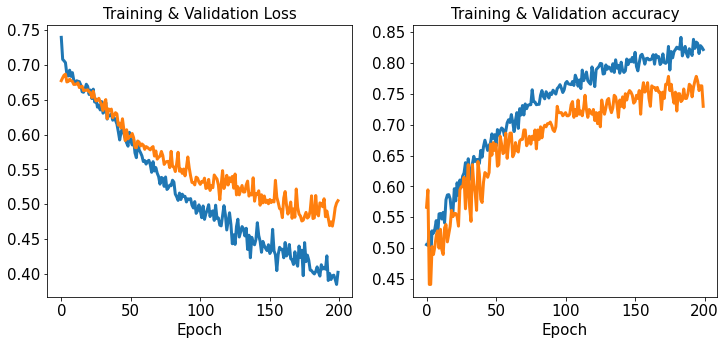

In [123]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [124]:
!pip install shap

In [125]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [126]:
shap_values  = explainer.shap_values(np.array(X_test_new))

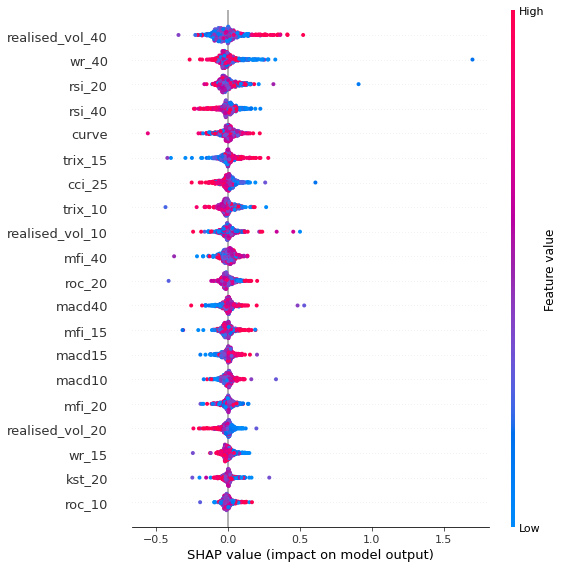

In [127]:
shap.summary_plot(shap_values[1], X_test_new)

In [128]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

In [129]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


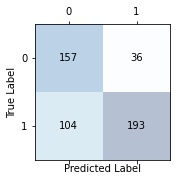

In [130]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [131]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.843
Recall: 0.650
F1: 0.734


In [132]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [133]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [134]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [10,20,25,30],
  }
]

In [135]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [136]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [137]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [138]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 30.8min finished


In [139]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/JNJ/xgb_JNJ_log_reg.pickle', "wb"))

In [140]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9204175490149643
Accuracy: 0.8673469387755102


Confusion Matrix


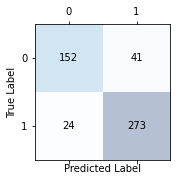

In [141]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [142]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.2, 'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__n_estimators': 200, 'fs__k': 30, 'fs__score_func': <function mutual_info_classif at 0x7fee319ee0d0>}


In [145]:
model = xgb.XGBClassifier(max_depth=8,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.2)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.189796	validation_0-logloss:0.655636	validation_1-error:0.32449	validation_1-logloss:0.672806
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.159694	validation_0-logloss:0.632223	validation_1-error:0.314286	validation_1-logloss:0.660919
[2]	validation_0-error:0.12602	validation_0-logloss:0.604516	validation_1-error:0.3	validation_1-logloss:0.649231
[3]	validation_0-error:0.110714	validation_0-logloss:0.580645	validation_1-error:0.283673	validation_1-logloss:0.637715
[4]	validation_0-error:0.097959	validation_0-logloss:0.561234	validation_1-error:0.269388	validation_1-logloss:0.628147
[5]	validation_0-error:0.091837	validation_0-logloss:0.544853	validation_1-error:0.287755	validation_1-logloss:0.622999
[6]	validation_0-error:0.080102	validation_0-logloss:0.519522	validation_1-error:0.269388	validation_1-logloss:0.607572
[7

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [146]:

# make predictions for test data
y_pred = model.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.94%


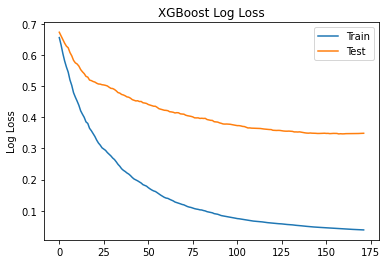

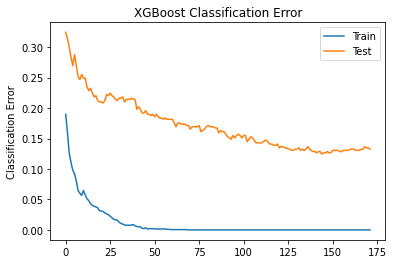

In [147]:
from matplotlib import pyplot

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [148]:
shap_values = shap.TreeExplainer(model).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


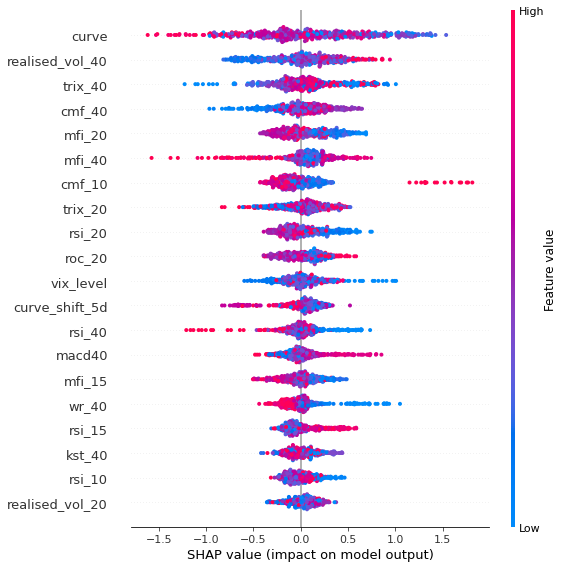

In [149]:
shap.summary_plot(shap_values, X_test_new)

In [150]:
predict = model.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


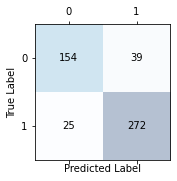

In [151]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()